In [856]:
# Загрузим основные библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [857]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV


In [858]:
%matplotlib inline

In [859]:
import warnings
warnings.filterwarnings('ignore')

In [860]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Функция сравнения точности обучающей модели на тренировочных и тестовых данных
    На выходе функция дает как числовые значения R2, так и графическое отоборажение рассеяния тестовых и тренировочных данных целевой переменной
    На вход нужно подать значения целевой переменной на тренировочных данных (имеющихся и предугаданных) и на тестовых данных аналогично.
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [861]:
# Загрузим датасет для тренировки 
# т.к. изначально мы не знаем одинаковые ли ошибки встречаются в тренировочном и тестовом датасетах, то проанализируем их по отдельности
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'


In [862]:
# Посмотрим шапку загруженного датасета
df_train = pd.read_csv(DATASET_PATH)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [863]:
# фОРМА
df_train.shape

(10000, 20)

In [864]:
# Далее начнем проверять целостность
# Сначала загрузим информацию
df_train.info()
# В информации видно что есть три столбца (Ecology_2, Ecology_3, Shops_2) с номинативными переменными. Обработаем их попозже

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [865]:
# Посмотрим основные параметры
df_train.describe()
# Проанализируем полученные результаты:
# 1 Столбец Id - для анализа не нужен, его мы удалим
# 2 Столбец DistrictId - на первый взгляд составлен корректно, min=0 возможно некорректен,
# но со 100% вероятностью это не сказать, поэтому оставим его таким, какой он есть
# 3 Столбец Rooms - все корректно, кроме значения min =0, в квартире не может не быть комнат. Этот момент нужно исправить.
# 4 Столбец Square - в принципе все корректно. max=641 м2 конечно многовато, но теоретически возможно такое значение.
                                            # а min=1.137 все же маловато, даже для японцев
# 5 Столбец LifeSquare - тут два момента: первый: max = 7480м2 все же многовато (мягко говоря), исправим. 
                                    #   второй: нужно отследить что бы LifeSquare (жилая площадь) была меньше чем Square(общая площадь)
# 6 Столбец KitchenSquare - тут все так же как и с жилой площадью в предыдущем пункте
# 7 Столбец Floor - криминала не видно, но проверим, что бы этаж был не выше чем общее количество этажей в доме
# 8 Столбец HouseFloor - все корректно, кроме min=0. Исправим
# 9 Столбец HouseYear - все корректно, но max= 20052010 (2.005201у+07) явная ошибка. Исправим.
# 10 Столбец Ecology_1 - вроде бы все нормально. min=0 вызывает вопросы, но оставим как есть.
# 11 Столбец Social_1 - вроде бы все нормально. min=0 вызывает вопросы, но оставим как есть.
# 12 Столбец Social_2 - все корректно
# 13 Столбец Social_3 - вроде бы все нормально. min=0 и 25% = 0 вызывают вопросы, но оставим как есть.
# 14 Столбец Healthcare_1 - вроде бы все нормально. min=0 вызывает вопросы, но оставим как есть.
# 15 Столбец Healthcare_2 - вроде бы все нормально. min=0 и 25% = 0 вызывают вопросы, но оставим как есть.
# 16 Столбец Shops_1 - все корректно
# 17 Столбец Price - целевая переменная. Проблем я не вижу.

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [866]:
len(df_train) - df_train.count() # перед началом правки найденных выше неточностей - проверим пропуски и NULLевые значения

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [867]:
df_train.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [868]:
# Исправим пропуски. В показатели здоровья поставим медианное значение, т.к. лучше все равно не придумать. 
# а вот в пропущенные значения жилой площади предлагаю подставить нулевые значения, что бы потом
# согласно значениям общей площади и площади кухни - более точно указать значения жилой площади
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = 0

In [869]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [870]:
# ПРоверим что получилось:
df_train.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [871]:
# А теперь будет править столбцы согласно вышенайденным замечаниям
# 1 Столбец Id - для анализа не нужен, его мы удалим
df_train = df_train[df_train.columns[1:]]

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.4+ MB


In [872]:
# 2 Столбец DistrictId - на первый взгляд составлен корректно, min=0 возможно некорректен,
# но со 100% вероятностью это не сказать, поэтому оставим его таким, какой он есть
# 3 Столбец Rooms - все корректно, кроме значения min =0: в квартире не может не быть комнат. Этот момент нужно исправить.
df_train[df_train['Rooms'] < 1]
# не будем обращать внимания (пока не будем) на то что еще и площади кухни = 0, это исправим позже
# для простановки количества комнат я нашел 3 пути:
#  вариант1 : поставить среднее значение. Плюсы: быстро. Минусы: все остальное :) А именно, что не будет соответствия между
# жилой площадью и количеством комнат.
# вариант2: посчитать среднюю жилую площадь для однокомнатных квартир, потом для двухкомнатных и т.д.
# Плюсы: можно с точностью определить количество комнат в строках, где стоят нули у комнат.
# Минусы: достаточно долго писать код, т.к. количество комнат разное, плюс код будет неуниверсальным, неавтоматизированным
# Из-за того, что в базу могут добавляться квартиры с количеством комнат, которое раньше не использовалось.
# вариант3(на мой взгляд самый оптимальный, его и используем): найдем коэффициент (из тех данных где есть оба значения) = LifeSquare/Rooms
# А потом умножим этот коэффициент на жилую площадь в строках, где количество комнат =0
# Округлив в сторону ближайшего целого - мы найдем искомое количество комнат с достаточно (на мой взгляд) высокой точностью.
# Однако для этого нам нужно что бы LifeSquare тоже везде отображалось корректно. Поэтому решим для начала проблемы 4, 5 и 6, 
# а потом вернемся к количеству комнат

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1981,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
2269,27,0.0,41.790881,0.000000,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
3911,28,0.0,49.483501,0.000000,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,6,0.0,81.491446,0.000000,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
6149,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
8834,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007


In [873]:
# 4 Столбец Square - в принципе все корректно. max=641 м2 конечно многовато, но теоретически возможно такое значение.
                                            # а min=1.137 все же маловато, даже для японцев
# 5 Столбец LifeSquare - тут два момента: первый: max = 7480м2 все же многовато (мягко говоря), исправим. 
                                    #   второй: нужно отследить что бы LifeSquare (жилая площадь) была меньше чем Square(общая площадь)
# 6 Столбец KitchenSquare - тут все так же как и с жилой площадью в предыдущем пункте    
# Первым делом посмотрим наличие квартир, в которых общая площадь меньше суммы площадей жилой и кухни (добавим 10 метров на прихожую, ванну и туалет)
df_train[df_train['Square'] < (df_train['LifeSquare'] + df_train['KitchenSquare'] + 10)]
# Таких объектов много. Это нужно исправить. Но нужно учесть, что во многих объектах жилая площадь и площадь кухни
# тоже отображаются некорректно. Следовательно, сначала нужно исправить их.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
14,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.565937
28,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,900.0,0,0,B,95338.198549
30,50,2.0,39.435351,23.377687,7.0,9,9.0,1965,0.007659,B,B,35,7077,56,2301.0,3,19,B,283877.617142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,54,2.0,38.599779,22.740244,6.0,2,12.0,1970,0.006076,B,B,30,5285,0,645.0,6,6,B,174497.101781
9982,8,1.0,39.195153,22.158768,9.0,12,12.0,1968,0.437885,B,B,23,5735,3,1084.0,0,5,B,177449.715863
9983,6,2.0,64.311707,61.920700,1.0,12,17.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,164356.212221
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [874]:
# Посмотрим объекты в которых площадь кухни меньше 5 и на обьекты с площадью кухни более 30.
df_train[(df_train['KitchenSquare'] < 5) | (df_train['KitchenSquare'] > 30)] 
#Таких объектов, к сожалению, очень много. Нужно исправлять.
#Исправлять предлагаю так: найдем среди строк где есть реальные значения общей площади и площади кухни следующий коэффициент:
#        Square/KitchenSquare после чего в строках, где площадь кухни не соответствует условной норме - мы исправим ее.


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,74,2.0,80.312926,0.000000,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156664
8,1,2.0,64.511437,0.000000,1.0,9,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,229102.795999
12,13,2.0,54.522805,31.759753,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,900.0,5,15,B,229220.372609
14,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.565937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,27,1.0,38.968338,0.000000,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,95529.569405
9986,1,2.0,64.994245,0.000000,1.0,9,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,200332.511658
9987,23,2.0,55.620092,0.000000,0.0,2,4.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,115797.553006
9994,23,2.0,64.864198,0.000000,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,171323.515653


In [875]:
# Здесь мы делаем выборку из строк, в которых как площадь кухни находится в "нормальных" границах (от 5 до 30)
# Так и общая площадь квартиры так же "нормальная", т.е. общая площадь > площадь кухни + 10 (где 10 - условная площадь комнаты)
df_kitchen = df_train[(df_train['KitchenSquare'] > 5) & (df_train['KitchenSquare'] < 30) & (df_train['Square'] > (df_train['KitchenSquare'] + 10))]

df_kitchen.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5.568000e+03,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000,5568.000000
mean,58.755568,1.962464,56.662287,34.286586,8.648168,8.535560,13.703843,5.588001e+03,0.122841,30.699533,6608.346624,6.599138,1068.546157,1.576688,4.839799,235982.744459
std,45.941850,0.893378,20.790260,19.185102,2.214627,5.004093,5.431459,2.686985e+05,0.120694,16.517467,4006.706597,16.791504,842.562816,1.513561,4.339820,99445.517467
min,0.000000,0.000000,25.410513,0.000000,6.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,21.000000,1.000000,41.243447,22.346094,7.000000,5.000000,9.000000,1.974000e+03,0.033494,21.000000,4346.000000,1.000000,750.000000,0.000000,1.000000,169160.527674
50%,48.000000,2.000000,53.727437,32.426044,8.000000,8.000000,14.000000,1.984000e+03,0.089040,30.000000,5776.000000,2.000000,900.000000,1.000000,4.000000,212073.045706
75%,90.000000,3.000000,66.621806,44.074245,10.000000,12.000000,17.000000,2.004000e+03,0.194489,42.000000,8004.000000,5.000000,1046.000000,3.000000,7.000000,286411.217655
max,208.000000,19.000000,641.065193,638.163193,29.000000,33.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994


In [876]:
# Вычислим коэффициент Square/KitchenSquare (предлагаю вычислить его по медианным данным, но есть и другие способы)
kitchen_сoeff=df_kitchen['Square'].median() / df_kitchen['KitchenSquare'].median()

kitchen_сoeff

6.715929632579473

In [877]:
# Коэффициент вычислен. Теперь доработаем значения площадей кухни, которые выходят за границы "нормальности"

df_train.loc[((df_train['KitchenSquare'] < 5) | (df_train['KitchenSquare'] > 30)), 'KitchenSquare'] = df_train['Square'] / kitchen_сoeff
# Проверим что получилось
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,29.339360,8.314503,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,78.079922,2.838137,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.000000,0.169278,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,17.627207,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,28.926861,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,41.427234,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,90.040546,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [878]:
# Проверим оставшиеся значения вне "нормы"
df_train[(df_train['KitchenSquare'] < 5) | (df_train['KitchenSquare'] > 30)] 
# Вышло вполне неплохо 129 элементов осталось. Но при этом много кухонь размером от 4 до 5 метров при общей площади до 40.
# Такое может быть в хрущевках. Поэтому давайте переделаем условие заменив 5 на 4.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,88,2.0,5.497061,67.628717,0.818511,24,22.0,1977,0.127376,B,B,43,8429,3,900.0,3,9,B,412511.088764
257,23,1.0,29.401008,0.000000,4.377802,4,17.0,2019,0.034656,B,B,0,168,0,900.0,0,0,B,71690.969474
381,23,1.0,29.567101,0.000000,4.402533,6,4.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,74012.218991
501,27,1.0,26.553188,0.000000,3.953762,25,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,114256.236153
769,30,1.0,29.947691,0.000000,4.459203,11,22.0,2018,0.000078,B,B,22,6398,141,1046.0,3,23,B,99110.577389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,23,1.0,32.998077,27.514488,4.913404,5,17.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,66921.308341
9903,23,1.0,32.879523,30.397748,4.895752,9,9.0,2015,0.034656,B,B,0,168,0,900.0,0,0,B,70098.380568
9951,25,1.0,33.516313,31.086243,4.990569,13,11.0,2015,0.069753,B,B,53,13670,4,900.0,1,11,B,148066.435795
9961,23,1.0,27.331108,0.000000,4.069594,10,12.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,60825.032060


In [879]:
df_train[(df_train['KitchenSquare'] < 4) | (df_train['KitchenSquare'] > 30)] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,88,2.0,5.497061,67.628717,0.818511,24,22.0,1977,0.127376,B,B,43,8429,3,900.0,3,9,B,412511.088764
501,27,1.0,26.553188,0.000000,3.953762,25,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,114256.236153
900,34,1.0,26.811587,0.000000,3.992238,18,0.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B,175399.643453
1316,27,1.0,4.633498,1.969969,0.689927,18,1.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,107604.269441
1476,101,1.0,23.583220,18.442768,3.511535,3,5.0,1968,0.225825,A,B,41,6558,7,1548.0,3,2,B,108232.647619
1608,6,1.0,2.596351,4.604943,0.386596,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
1891,0,1.0,17.498542,13.446544,2.605528,7,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B,88871.750230
1981,27,0.0,212.932361,211.231125,31.705568,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
3084,112,1.0,20.213128,13.800281,3.009729,5,9.0,1974,0.069660,B,B,31,6119,4,900.0,1,2,B,113050.229914
3280,27,1.0,4.380726,40.805837,0.652289,10,17.0,2013,0.211401,B,B,9,1892,0,900.0,0,1,B,97560.720383


In [880]:
# Значений осталось немного. При этом больше 30 метров кухонь осталось 2. 
# Тут можно уже поставить условную кухню в 8 метров, либо медианный метраж кухни. Выберем второе.
df_train.loc[((df_train['KitchenSquare'] < 4) | (df_train['KitchenSquare'] > 30)), 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_train.describe()
# С кухнями закончили. Переходим к жилой площади.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,29.339360,8.323692,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,78.079922,2.683610,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.000000,4.009884,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,17.627207,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,28.926861,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,41.427234,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [881]:
# С жилой площадью несколько сложнее, т.к. тут есть прямая зависимость от количества комнат (в отличие от площади кухни)
# С одной стороны можно отдельно исходя из количества комнат делать выборки выходящих за "нормальные" значения жилой площади
# Но если квартира новая, да еще и свободнйо планировки, то тут нет привязки площади к количеству комнат. ПОэтому упустим этот момент
# Посмотрим независимо от количества комнат - выборку жилой площади выходящей за границы, так сказать, "нормальности".
# Пусть эти границы будут между 6 (для студий) и 300 (для бооооольших квартир)
df_train[(df_train['LifeSquare'] < 6) | (df_train['LifeSquare'] > 300)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,74,2.0,80.312926,0.0,11.958572,14,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156664
8,1,2.0,64.511437,0.0,9.605735,9,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,229102.795999
21,27,2.0,64.711835,0.0,9.635574,15,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,127200.026511
23,54,3.0,118.907612,0.0,17.705309,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
25,74,2.0,82.667915,0.0,12.309229,16,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,244145.827069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,27,1.0,38.968338,0.0,5.802374,10,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,95529.569405
9986,1,2.0,64.994245,0.0,9.677625,9,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,200332.511658
9987,23,2.0,55.620092,0.0,8.281816,2,4.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,115797.553006
9994,23,2.0,64.864198,0.0,9.658261,17,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,171323.515653


In [882]:
# 2321 - многовато, но это за счет пропущенных и замененных на 0.
# Попробуем такой "ход конем": для корректировки жилой площади в этих 208 строках
# Мы вычтем из общей площади - площадь кухни, и другую нежилую площадь (ванной комнаты, туалета, балкона/2 (по правилам так положено) и т.д.)
df_train.loc[((df_train['LifeSquare'] < 6) | (df_train['LifeSquare'] > 300)), 'LifeSquare'] = df_train['Square'] - df_train['KitchenSquare'] - 10
df_train[(df_train['LifeSquare'] < 6) | (df_train['LifeSquare'] > 300)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1316,27,1.0,4.633498,-13.366502,8.0,18,1.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,107604.269441
1608,6,1.0,2.596351,-15.403649,8.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3413,5,1.0,5.129222,-12.870778,8.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4262,9,2.0,604.705972,586.705972,8.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,102,1.0,409.425181,389.425181,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
4853,27,0.0,2.377248,-15.622752,8.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
4900,27,3.0,4.390331,-13.609669,8.0,8,19.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B,161379.067034
6392,1,1.0,1.136859,-16.863141,8.0,3,1.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,181434.825589
6945,62,2.0,17.414181,-0.585819,8.0,4,20.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,180750.471749
6977,30,2.0,641.065193,621.065193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [883]:
# Понятно, что некоторая часть этих данных после доработки получилась некорректной, поэтому поставим медианные значения.
df_train.loc[((df_train['LifeSquare'] < 6) | (df_train['LifeSquare'] > 300)), 'LifeSquare'] = df_train['LifeSquare'].median()

df_train[(df_train['LifeSquare'] < 6) | (df_train['LifeSquare'] > 300)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [884]:
df_train.describe()
# C жилой площадью тоже закончили. Переходим к общей площади квартиры

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.900233,8.323692,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,17.349552,2.683610,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,8.553188,4.009884,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,24.564305,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,33.927206,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,46.148420,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,263.542020,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [885]:
# Тут уже немного попроще. Сразу повторно (выше мы его уже смотрели и было более 3000 строк) посмотрим условие "нормальности", которое построим на следующей базе:
# Общая площадь квартиры не может быть меньше суммы площадей жилой и кухни, плюс добавим 10 метров на прихожую, ванну и туалет)
# Смотрим только в меньшую сторону, т.к. в большую смотреть достаточно сложно ввиду возможного наличия различных нежилых террас
df_train[df_train['Square'] < (df_train['LifeSquare'] + df_train['KitchenSquare'] + 10)]


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,53,2.0,44.947953,29.197612,6.692737,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
14,27,1.0,53.769097,52.408027,8.006203,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.565937
28,23,1.0,42.530043,43.967759,6.332711,3,9.0,2014,0.034656,B,B,0,168,0,900.0,0,0,B,95338.198549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,54,2.0,38.599779,22.740244,6.000000,2,12.0,1970,0.006076,B,B,30,5285,0,645.0,6,6,B,174497.101781
9982,8,1.0,39.195153,22.158768,9.000000,12,12.0,1968,0.437885,B,B,23,5735,3,1084.0,0,5,B,177449.715863
9983,6,2.0,64.311707,61.920700,9.575995,12,17.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,164356.212221
9998,75,2.0,43.602562,33.840147,8.000000,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [886]:
# Собственно дальше можно быстро это дело поправить:
df_train.loc[df_train['Square'] < (df_train['LifeSquare'] + df_train['KitchenSquare'] + 10), 'Square'] = df_train['LifeSquare'] + df_train['KitchenSquare'] + 10

df_train[df_train['Square'] < (df_train['LifeSquare'] + df_train['KitchenSquare'] + 10)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [887]:
df_train.describe()
# Заметим все же что есть слишком большая нежилая площадь. Что "крайнемаловероятно". Попробуем это проанализировать
# Взяв за границу "нормы" сумму жилой площади, площади кухни и 150 квадратных метров дополнительных.


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,59.137733,37.900233,8.323692,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,22.247961,17.349552,2.683610,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,26.553188,8.553188,4.009884,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.944377,24.564305,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,55.141231,33.927206,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,68.671083,46.148420,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,263.542020,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [888]:
df_train[df_train['Square'] > (df_train['LifeSquare'] + df_train['KitchenSquare'] + 150)]
# Всего 3 значения, при том все эти строки ранее правленные (по жилая площадь). Поправим и их

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,9,2.0,604.705972,33.927206,8.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,102,1.0,409.425181,33.927206,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,30,2.0,641.065193,33.927206,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [889]:
df_train.loc[df_train['Square'] > (df_train['LifeSquare'] + df_train['KitchenSquare'] + 150), 'Square'] = df_train['LifeSquare'] + df_train['KitchenSquare'] + 10

df_train.describe()
# Готово. Переходим к комнатам.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,58.988192,37.900233,8.323692,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.839512,20.470806,17.349552,2.683610,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,0.000000,26.553188,8.553188,4.009884,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.944377,24.564305,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,55.125690,33.927206,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,68.602244,46.148420,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,278.542020,263.542020,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [890]:
df_train[(df_train['Rooms'] < 1) | (df_train['Rooms'] > 6)]
# Как можно видеть - квартир с комнатами менее одной и более 6 немного. Давайте это быстро поправим осуществив ранее выбранный способ:
# Напомню способ: вариант3(на мой взгляд самый оптимальный, его и используем): найдем коэффициент = LifeSquare/Rooms
# А потом умножим этот коэффициент на жилую площадь в строках, где количество комнат = 0
# Округлив в сторону ближайшего целого - мы найдем искомое количество комнат с достаточно (на мой взгляд) высокой точностью.


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,57,10.0,59.056975,36.223072,10.000000,22,22.0,2002,0.090799,B,B,74,19083,2,900.0,5,15,B,317265.323792
1397,27,0.0,166.827343,136.215499,20.611844,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1454,1,19.0,42.006046,21.779288,7.000000,17,17.0,2014,0.007122,B,B,1,264,0,900.0,0,1,B,78364.616704
1981,27,0.0,229.231125,211.231125,8.000000,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
2269,27,0.0,41.790881,25.568231,6.222650,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
3911,28,0.0,49.483501,32.115422,7.368079,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,6,0.0,81.491446,59.357393,12.134053,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,27,0.0,51.927206,33.927206,8.000000,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
6149,88,0.0,38.697117,19.345131,9.000000,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
8834,27,0.0,108.193300,85.125471,13.067828,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007


In [891]:
df_rooms = df_train[(df_train['Rooms'] >= 1) & (df_train['Rooms'] <= 6)]

rooms_coeff = df_rooms['LifeSquare'].median() / df_rooms['Rooms'].median()

rooms_coeff

16.963602817167285

In [892]:
# 17 м2 в среднем на комнату - вполне реальный коэффициент.
df_train.loc[(df_train['Rooms'] < 1) | (df_train['Rooms'] > 6), 'Rooms'] = round(df_train['LifeSquare'] / rooms_coeff)

df_train[(df_train['Rooms'] < 1) | (df_train['Rooms'] > 6)]
# Получившиеся значения вполне реальны, поэтому закончим с комнатами и перейдем к этажам

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,27,8.0,166.827343,136.215499,20.611844,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
1981,27,12.0,229.231125,211.231125,8.000000,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887


In [893]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890600,58.988192,37.900233,8.323692,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.821401,20.470806,17.349552,2.683610,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,1.000000,26.553188,8.553188,4.009884,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.944377,24.564305,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,55.125690,33.927206,8.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,68.602244,46.148420,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,12.000000,278.542020,263.542020,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [894]:
# 7 Столбец Floor - криминала не видно, но проверим, что бы этаж был не выше чем общее количество этажей в доме
# 8 Столбец HouseFloor - все корректно, кроме min=0. Исправим
# Собственно можно 7 и 8 исправить в одно действие: т.к. нет квартир на нулевом этаже и на сильно больших этажах, значит можно допустить, что
# этажи квартир указаны корректно. Значит исправим общее количество этажей в доме по условию, что они должны быть не меньше,
# чем этаж квартиры.

df_train[df_train['Floor'] > df_train['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,74,2.0,80.312926,58.354354,11.958572,14,0.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156664
14,27,1.0,70.414230,52.408027,8.006203,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.565937
16,27,2.0,49.360648,31.993964,5.000000,6,5.0,1983,0.051815,B,B,5,1227,0,900.0,0,0,B,117000.381287
21,27,2.0,64.711835,45.076261,9.635574,15,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,127200.026511
23,54,3.0,118.907612,91.202302,17.705309,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,52,3.0,64.074977,47.633428,6.000000,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.880156
9985,27,1.0,38.968338,23.165964,5.802374,10,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,95529.569405
9989,96,3.0,90.055233,47.860231,11.000000,26,24.0,2005,0.041116,B,B,53,14892,4,900.0,1,4,B,441108.911237
9991,3,3.0,101.622794,51.628780,12.000000,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504


In [895]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor'] = df_train['Floor']

df_train[df_train['Floor'] > df_train['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [896]:
df_train.describe()
# Вроде бы все нормально с этажами. Переходим к годам.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890600,58.988192,37.900233,8.323692,8.526700,13.435700,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.821401,20.470806,17.349552,2.683610,5.241148,6.094012,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,1.000000,26.553188,8.553188,4.009884,1.000000,1.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.944377,24.564305,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,55.125690,33.927206,8.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,68.602244,46.148420,10.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,12.000000,278.542020,263.542020,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [897]:
# 9 Столбец HouseYear - все корректно, но max= 20052010 (2.005201у+07) явная ошибка. Исправим.
# Посмотрим наличие строк, в которых год постройки дома выходит за границы 2020 (минимально значение 1910 - вполне корректно, оставим его).
df_train[df_train['HouseYear'] > 2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,109,1.0,39.239714,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [898]:
# Два всего значения, при том в первом случае это либо 2005 либо 2011 год, а во втором очевидно, что 1968.
# Исправим их вручную
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2005

df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968

df_train[df_train['HouseYear'] > 2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [899]:
df_train.describe()


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890600,58.988192,37.900233,8.323692,8.526700,13.435700,1984.865700,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,43.587592,0.821401,20.470806,17.349552,2.683610,5.241148,6.094012,18.411517,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.000000,1.000000,26.553188,8.553188,4.009884,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,42.944377,24.564305,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,55.125690,33.927206,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,68.602244,46.148420,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,209.000000,12.000000,278.542020,263.542020,30.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [900]:
# Посмотрим на номинативные переменные
df_train["Ecology_2"]

0       B
1       B
2       B
3       B
4       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 10000, dtype: object

In [901]:
# Воспользуемся готовым решением, предложенным во время консультации по курсовому проекту и заменим А и Б на 0 и 1 соответственно.
# Добавив новые столбцы
df_train['Ecology_2_bin'] = df_train['Ecology_2'].replace({'A':0, 'B':1})
df_train['Ecology_3_bin'] = df_train['Ecology_3'].replace({'A':0, 'B':1})
df_train['Shops_2_bin'] = df_train['Shops_2'].replace({'A':0, 'B':1})

In [902]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890600,58.988192,37.900233,8.323692,8.526700,13.435700,1984.865700,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,43.587592,0.821401,20.470806,17.349552,2.683610,5.241148,6.094012,18.411517,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,0.000000,1.000000,26.553188,8.553188,4.009884,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,20.000000,1.000000,42.944377,24.564305,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,36.000000,2.000000,55.125690,33.927206,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,75.000000,2.000000,68.602244,46.148420,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,209.000000,12.000000,278.542020,263.542020,30.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [903]:
df_train.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')

In [904]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
Ecology_2_bin    10000 non-null int64
Ecology_3_bin    10000 non-null int64
Shops_2_bin      10000 non-null int64
dtypes: float64(8), int64(11), object

In [905]:
# Закончили с тренировочными данными. Теперь повторим все это на тестовых.
DATASET_PATH_TEST = 'test.csv'
PREPARED_DATASET_PATH_TEST = 'test_prepared.csv'

In [906]:
df_test = pd.read_csv(DATASET_PATH_TEST)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [907]:
df_test.shape
# Видим, что тестовая выборка в два раза меньше тренировочной

(5000, 19)

In [908]:
df_test.info()
# Видимо что часть данных отсутствует. В остальном структура данных тестовой таблицы совпадает с тренировочной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [909]:
df_test.describe()
# Забросы типовые как и в тренировочных данных. Значит и исправлять будем аналогично.

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [910]:
len(df_test) - df_test.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [911]:
df_test.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [912]:
df_test.loc[df_test['LifeSquare'].isnull(), 'LifeSquare'] = 0

In [913]:
df_test.loc[df_test['Healthcare_1'].isnull(), 'Healthcare_1'] = df_test['Healthcare_1'].median()

In [914]:
df_test.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [915]:
df_test = df_test[df_test.columns[1:]]

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(8), object(3)
memory usage: 703.2+ KB


In [916]:
# Посмотрим объекты в которых площадь кухни меньше 5 и на обьекты с площадью кухни более 30.
df_test[(df_test['KitchenSquare'] < 5) | (df_test['KitchenSquare'] > 30)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,74,2.0,69.263183,0.000000,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
5,53,1.0,40.675627,0.000000,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
11,6,3.0,84.625350,0.000000,1.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,23,1.0,39.610426,38.187571,1.0,6,18.0,2013,0.034656,B,B,0,168,0,900.0,0,0,B
4985,1,1.0,46.597283,0.000000,1.0,17,24.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
4987,53,3.0,80.102103,0.000000,1.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
4998,62,2.0,81.305222,0.000000,0.0,4,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A


In [917]:
df_kitchen_test = df_test[(df_test['KitchenSquare'] > 5) & (df_test['KitchenSquare'] < 30) & (df_test['Square'] > (df_test['KitchenSquare'] + 10))]

df_kitchen_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,59.628561,1.978276,56.836255,34.493598,8.551994,8.588675,13.674501,1986.673433,0.123532,30.653846,6612.907051,6.254986,1059.613248,1.545584,4.748575
std,46.397938,0.888047,18.362482,15.920249,2.104028,5.198240,5.613882,18.975427,0.121257,16.630303,4068.405109,15.127995,840.269578,1.485731,4.198261
min,0.000000,0.000000,28.240534,0.000000,6.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,1.000000,41.398040,22.667289,7.000000,5.000000,9.000000,1973.000000,0.034331,21.000000,4231.000000,1.000000,750.000000,0.000000,1.000000
50%,52.000000,2.000000,54.181315,32.921395,8.000000,8.000000,14.000000,1983.000000,0.087619,30.000000,5776.000000,3.000000,900.000000,1.000000,4.000000
75%,91.000000,3.000000,67.066202,44.548444,10.000000,12.000000,17.000000,2004.000000,0.194489,42.000000,8004.000000,5.000000,1020.000000,3.000000,6.000000
max,212.000000,17.000000,223.453689,303.071094,24.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [918]:
# Вычислим коэффициент Square/KitchenSquare (предлагаю вычислить его по медианным данным, но есть и другие способы)
kitchen_test_сoeff=df_kitchen_test['Square'].median() / df_kitchen_test['KitchenSquare'].median()

kitchen_test_сoeff

6.772664327379764

In [919]:
# Коэффициент вычислен. Теперь доработаем значения площадей кухни, которые выходят за границы "нормальности"

df_test.loc[((df_test['KitchenSquare'] < 5) | (df_test['KitchenSquare'] > 30)), 'KitchenSquare'] = df_test['Square'] / kitchen_test_сoeff
# Проверим что получилось
df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,28.630546,8.226967,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.838594,19.092787,21.613779,2.682174,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.000000,0.203545,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,17.873731,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,29.118838,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,41.769526,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,32.651665,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [920]:
df_test[(df_test['KitchenSquare'] < 4) | (df_test['KitchenSquare'] > 33)] #33 поставили так как есть значение с метражом кухни в 32, что вполне допустимо

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
58,21,1.0,21.452899,15.798509,3.167572,11,9.0,1972,0.194489,B,B,47,8004,3,125.0,3,5,B
66,53,1.0,1.378543,1.353573,0.203545,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
282,66,1.0,24.170511,12.632946,3.568834,10,9.0,1973,0.161976,B,A,31,7010,5,4508.0,3,7,B
557,101,1.0,19.043894,13.941145,2.811876,4,5.0,1970,0.225825,A,B,41,6558,7,1548.0,3,2,B
608,30,1.0,2.645046,4.338755,0.390547,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
627,90,1.0,25.329567,16.186488,3.739971,5,5.0,1966,0.265089,B,B,37,5288,0,1937.0,3,2,B
837,27,1.0,5.647458,1.501582,0.833861,1,1.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
1165,6,1.0,5.100672,3.861780,0.753126,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
1195,101,1.0,18.149267,9.698766,2.679782,4,5.0,1967,0.225825,A,B,41,6558,7,1548.0,3,2,B
1340,7,1.0,23.681687,13.699489,3.496657,4,9.0,1971,0.130618,B,B,39,10418,9,900.0,1,9,B


In [921]:
df_test.loc[((df_test['KitchenSquare'] < 4) | (df_test['KitchenSquare'] > 33)), 'KitchenSquare'] = df_test['KitchenSquare'].median()

df_test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,28.630546,8.257424,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.838594,19.092787,21.613779,2.645476,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.000000,4.083838,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,17.873731,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,29.118838,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,41.769526,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,32.651665,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [922]:
# Пройдемся по жилой площади
df_test[(df_test['LifeSquare'] < 6) | (df_test['LifeSquare'] > 300)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,74,2.0,69.263183,0.000000,10.226874,6,1.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
5,53,1.0,40.675627,0.000000,6.005853,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
11,6,3.0,84.625350,0.000000,12.495134,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
14,27,1.0,37.555197,0.000000,5.545114,5,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
18,27,3.0,82.652818,5.690155,12.203885,4,17.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,95,1.0,45.542940,0.000000,6.724523,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B
4985,1,1.0,46.597283,0.000000,6.880200,17,24.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B
4987,53,3.0,80.102103,0.000000,11.827266,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
4998,62,2.0,81.305222,0.000000,12.004909,4,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A


In [923]:
df_test.loc[((df_test['LifeSquare'] < 6) | (df_test['LifeSquare'] > 300)), 'LifeSquare'] = df_test['Square'] - df_test['KitchenSquare'] - 10

df_test[(df_test['LifeSquare'] < 6) | (df_test['LifeSquare'] > 300)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
66,53,1.0,1.378543,-16.621457,8.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
608,30,1.0,2.645046,-15.354954,8.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
837,27,1.0,5.647458,-12.352542,8.0,1,1.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
1165,6,1.0,5.100672,-12.899328,8.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4490,27,1.0,2.372101,-15.627899,8.0,2,17.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B
4540,6,1.0,4.967143,-13.032857,8.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B
4902,45,1.0,1.975769,-16.024231,8.0,1,1.0,1977,0.195781,B,B,23,5212,6,900.0,3,2,B


In [924]:
df_test.loc[((df_test['LifeSquare'] < 6) | (df_test['LifeSquare'] > 300)), 'LifeSquare'] = df_test['LifeSquare'].median()

df_test[(df_test['LifeSquare'] < 6) | (df_test['LifeSquare'] > 300)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [925]:
df_test.describe()
# C жилой площадью тоже закончили. Переходим к общей площади квартиры

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,38.124108,8.257424,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.838594,19.092787,16.756907,2.645476,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,0.000000,1.378543,8.719723,4.083838,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,24.863087,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,34.243095,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,46.506924,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,169.901701,32.651665,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [926]:
df_test[df_test['Square'] < (df_test['LifeSquare'] + df_test['KitchenSquare'] + 10)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,190,1.0,13.597819,15.948246,12.000000,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
4,27,1.0,47.527111,43.387569,7.017491,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
5,53,1.0,40.675627,24.669774,6.005853,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,23,2.0,68.099538,64.843025,10.055059,2,17.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
7,32,2.0,48.193897,32.857644,6.000000,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,126,1.0,36.233212,22.885434,9.000000,3,12.0,1969,0.333892,B,B,30,6564,1,900.0,0,0,B
4989,39,2.0,44.203592,30.191691,6.000000,10,9.0,1972,0.428826,B,B,25,5011,8,730.0,0,2,B
4991,64,2.0,45.493240,32.022565,6.000000,4,9.0,1974,0.135650,B,B,46,7960,6,350.0,3,11,B
4994,39,2.0,45.131282,30.780551,6.000000,2,5.0,1965,0.428826,B,B,25,5011,8,730.0,0,2,B


In [927]:
df_test.loc[df_test['Square'] < (df_test['LifeSquare'] + df_test['KitchenSquare'] + 10), 'Square'] = df_test['LifeSquare'] + df_test['KitchenSquare'] + 10

df_test[df_test['Square'] < (df_test['LifeSquare'] + df_test['KitchenSquare'] + 10)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [928]:
df_test.describe()
# в отличие от тренировочных данных - в тестовых больщих общих площадей нет. Поэтому перейдем дальше к комнатам.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.910000,59.220691,38.124108,8.257424,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.838594,20.138405,16.756907,2.645476,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,0.000000,26.719723,8.719723,4.083838,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,43.315778,24.863087,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.000000,55.304738,34.243095,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,69.552666,46.506924,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,169.901701,32.651665,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [929]:
df_test[(df_test['Rooms'] < 1) | (df_test['Rooms'] > 6)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,58,0.0,140.941795,113.692424,17.249371,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,27,0.0,76.345154,42.820796,12.000000,14,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B
3398,111,17.0,52.866107,32.528342,8.000000,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [930]:
df_rooms_test = df_test[(df_test['Rooms'] >= 1) & (df_test['Rooms'] <= 6)]

rooms_test_coeff = df_rooms_test['LifeSquare'].median() / df_rooms_test['Rooms'].median()

rooms_test_coeff

17.119960756786373

In [931]:
df_test.loc[(df_test['Rooms'] < 1) | (df_test['Rooms'] > 6), 'Rooms'] = round(df_test['LifeSquare'] / rooms_test_coeff)

df_test[(df_test['Rooms'] < 1) | (df_test['Rooms'] > 6)]
# Все в норме, переходим дальше

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,58,7.0,140.941795,113.692424,17.249371,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B


In [932]:
df_test.describe()
# Здесь аналогично тренировочным данным - столбец этажа квартиры заполнен корректно. Его и возьмем за основу

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.90900,59.220691,38.124108,8.257424,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.81342,20.138405,16.756907,2.645476,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,1.00000,26.719723,8.719723,4.083838,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.00000,43.315778,24.863087,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.00000,55.304738,34.243095,8.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.00000,69.552666,46.506924,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,7.00000,223.453689,169.901701,32.651665,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [933]:
df_test[df_test['Floor'] > df_test['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,74,2.0,69.263183,49.036310,10.226874,6,1.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
10,61,3.0,64.543658,42.651541,7.000000,10,9.0,1981,0.300323,B,B,52,10311,6,900.0,1,9,B
14,27,1.0,37.555197,22.010083,5.545114,5,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
22,27,3.0,83.670032,46.358356,12.354079,8,0.0,2015,0.072158,B,B,2,629,1,900.0,0,0,A
24,27,2.0,69.849239,49.535833,10.313406,3,0.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,95,1.0,45.542940,28.818417,6.724523,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B
4989,39,2.0,46.191691,30.191691,6.000000,10,9.0,1972,0.428826,B,B,25,5011,8,730.0,0,2,B
4993,113,2.0,46.627882,27.058739,5.000000,6,5.0,1969,0.307467,B,A,30,5048,9,325.0,2,5,B
4997,12,3.0,77.842178,48.282625,9.000000,23,22.0,1989,0.090799,B,B,74,19083,2,900.0,5,15,B


In [934]:
df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'HouseFloor'] = df_test['Floor']

df_test[df_test['Floor'] > df_test['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [935]:
df_test.describe()
# С этажами проблему решили, а с годом постройки в тестовых данных изначально все нормально. Поэтому переходим к номинативным переменным.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.90900,59.220691,38.124108,8.257424,8.632000,13.395000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800
std,44.179466,0.81342,20.138405,16.756907,2.645476,5.483228,6.231945,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365
min,0.000000,1.00000,26.719723,8.719723,4.083838,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.00000,43.315778,24.863087,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000
50%,37.000000,2.00000,55.304738,34.243095,8.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.00000,69.552666,46.506924,10.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,7.00000,223.453689,169.901701,32.651665,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [936]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B
1,74,2.0,69.263183,49.036310,10.226874,6,6.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
2,190,1.0,37.948246,15.948246,12.000000,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B
4,27,1.0,60.405060,43.387569,7.017491,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A


In [937]:
df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1})

In [938]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
Ecology_2_bin    5000 non-null int64
Ecology_3_bin    5000 non-null int64
Shops_2_bin      5000 non-null int64
dtypes: float64(7), int64(11), object(3)
memory usage: 820.4+ KB


In [939]:
df_test.to_csv(PREPARED_DATASET_PATH_TEST, index=False, encoding='utf-8')

In [940]:
print(df_train.shape)
print(df_test.shape)
# разница 22/21 - в наличии целевой переменной в train

(10000, 22)
(5000, 21)


In [941]:
# Построим новые признаки
# Вначале позаимствуем пару признаков из последнего вебинара
# Размер района (количество квартир выставленных на продажу в каждом районе)
district_size = df_train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [942]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')

df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,B,...,900.0,0,11,B,184966.930730,1,1,1,22,0
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,B,...,240.0,1,16,B,300009.450063,1,1,1,87,0
2,53,2.0,45.890349,29.197612,6.692737,8,12.0,1968,0.049637,B,...,229.0,1,3,B,220925.908524,1,1,1,174,1
3,58,2.0,71.731512,52.731512,9.000000,8,17.0,1977,0.437885,B,...,1084.0,0,5,B,175616.227217,1,1,1,179,1
4,99,1.0,40.776169,23.776169,7.000000,11,12.0,1976,0.012339,B,...,2078.0,2,4,B,150226.531644,1,1,1,97,0


In [943]:
district_size_test = df_test['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

df_test = df_test.merge(district_size_test, on='DistrictId', how='left')

df_test['IsDistrictLarge'] = (df_test['DistrictSize'] > 100).astype(int)

df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,B,...,1,900.0,0,0,B,1,1,1,91,0
1,74,2.0,69.263183,49.036310,10.226874,6,6.0,1977,0.075779,B,...,3,900.0,0,2,B,1,1,1,61,0
2,190,1.0,37.948246,15.948246,12.000000,2,5.0,1909,0.000000,B,...,87,4702.0,5,5,B,1,1,1,2,0
3,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,B,...,3,900.0,3,3,B,1,1,1,49,0
4,27,1.0,60.405060,43.387569,7.017491,17,17.0,2017,0.072158,B,...,1,900.0,0,0,A,1,1,0,391,1


In [944]:
# Добавим среднюю цену по району в зависимости от количества комнат
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146574.015522
4,1,2.0,202706.090239


In [945]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,B,...,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,B,...,1,16,B,300009.450063,1,1,1,87,0,300009.450063
2,53,2.0,45.890349,29.197612,6.692737,8,12.0,1968,0.049637,B,...,1,3,B,220925.908524,1,1,1,174,1,263206.223152
3,58,2.0,71.731512,52.731512,9.000000,8,17.0,1977,0.437885,B,...,0,5,B,175616.227217,1,1,1,179,1,166809.665642
4,99,1.0,40.776169,23.776169,7.000000,11,12.0,1976,0.012339,B,...,2,4,B,150226.531644,1,1,1,97,0,158539.052715


In [946]:
# Перенесем на тестовую таблицу
df_test = df_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [947]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,B,...,900.0,0,0,B,1,1,1,91,0,166809.665642
1,74,2.0,69.263183,49.036310,10.226874,6,6.0,1977,0.075779,B,...,900.0,0,2,B,1,1,1,61,0,243031.695525
2,190,1.0,37.948246,15.948246,12.000000,2,5.0,1909,0.000000,B,...,4702.0,5,5,B,1,1,1,2,0,NaN
3,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,B,...,900.0,3,3,B,1,1,1,49,0,222227.584211
4,27,1.0,60.405060,43.387569,7.017491,17,17.0,2017,0.072158,B,...,900.0,0,0,A,1,1,0,391,1,118327.090620


In [948]:
# Предлагаю предыдущий признак немного модернизировать и добавить еще год постройки дома убрав район
med_price_by_Rooms_HouseYear = df_train.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByRoomsYear'})

med_price_by_Rooms_HouseYear.head()

,HouseYear,Rooms,MedPriceByRoomsYear
0,1910,1.0,287954.720682
1,1912,1.0,262279.813915
2,1912,4.0,284884.959104
3,1914,2.0,423580.477982
4,1916,3.0,284608.939261


In [949]:
df_train = df_train.merge(med_price_by_Rooms_HouseYear, on=['HouseYear', 'Rooms'], how='left')
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByRoomsYear
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,B,...,11,B,184966.930730,1,1,1,22,0,207786.135836,194564.197909
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,B,...,16,B,300009.450063,1,1,1,87,0,300009.450063,268711.924550
2,53,2.0,45.890349,29.197612,6.692737,8,12.0,1968,0.049637,B,...,3,B,220925.908524,1,1,1,174,1,263206.223152,197287.354681
3,58,2.0,71.731512,52.731512,9.000000,8,17.0,1977,0.437885,B,...,5,B,175616.227217,1,1,1,179,1,166809.665642,182384.172250
4,99,1.0,40.776169,23.776169,7.000000,11,12.0,1976,0.012339,B,...,4,B,150226.531644,1,1,1,97,0,158539.052715,167850.178678


In [950]:
df_test = df_test.merge(med_price_by_Rooms_HouseYear, on=['HouseYear', 'Rooms'], how='left')

In [951]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
DistrictId             5000 non-null int64
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             5000 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int64
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null object
Ecology_3              5000 non-null object
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           5000 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null object
Ecology_2_bin          5000 non-null int64
Ecology_3_bin          5000 non-null int64
Shops_2_bin     

In [952]:
df_test.loc[df_test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = df_test['MedPriceByDistrict'].median()
df_test.loc[df_test['MedPriceByRoomsYear'].isnull(), 'MedPriceByRoomsYear'] = df_test['MedPriceByRoomsYear'].median()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
DistrictId             5000 non-null int64
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             5000 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int64
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null object
Ecology_3              5000 non-null object
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           5000 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null object
Ecology_2_bin          5000 non-null int64
Ecology_3_bin          5000 non-null int64
Shops_2_bin     

In [953]:
# Попробуем создать следующий признак: средняя цена квадратного метра в зависимости от района.
df_train['mean_price_m2'] = df_train['Price'] / df_train['Square']

In [954]:
dist_price_m2 = df_train.groupby(['DistrictId'], as_index=False).agg({'mean_price_m2':'mean'})\
                       .rename(columns={'mean_price_m2':'dist_price_m2'})

dist_price_m2.head()

,DistrictId,dist_price_m2
0,0,3511.617751
1,1,3017.655377
2,2,4448.429290
3,3,3680.562740
4,4,5053.261304


In [955]:
df_train = df_train.merge(dist_price_m2, on=['DistrictId'], how='left')
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByRoomsYear,mean_price_m2,dist_price_m2
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,B,...,184966.930730,1,1,1,22,0,207786.135836,194564.197909,3854.958571,4323.457039
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,B,...,300009.450063,1,1,1,87,0,300009.450063,268711.924550,4567.491245,4222.048912
2,53,2.0,45.890349,29.197612,6.692737,8,12.0,1968,0.049637,B,...,220925.908524,1,1,1,174,1,263206.223152,197287.354681,4814.212866,4595.395633
3,58,2.0,71.731512,52.731512,9.000000,8,17.0,1977,0.437885,B,...,175616.227217,1,1,1,179,1,166809.665642,182384.172250,2448.243766,2860.938822
4,99,1.0,40.776169,23.776169,7.000000,11,12.0,1976,0.012339,B,...,150226.531644,1,1,1,97,0,158539.052715,167850.178678,3684.174726,3816.814280


In [956]:
#df_test = df_test[df_test.columns[:-2]]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
DistrictId             5000 non-null int64
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             5000 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int64
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null object
Ecology_3              5000 non-null object
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           5000 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null object
Ecology_2_bin          5000 non-null int64
Ecology_3_bin          5000 non-null int64
Shops_2_bin     

In [957]:
df_test = df_test.merge(dist_price_m2, on=['DistrictId'], how='left')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
DistrictId             5000 non-null int64
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             5000 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int64
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null object
Ecology_3              5000 non-null object
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           5000 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null object
Ecology_2_bin          5000 non-null int64
Ecology_3_bin          5000 non-null int64
Shops_2_bin     

In [958]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByRoomsYear,dist_price_m2
0,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,B,...,0,B,1,1,1,91,0,166809.665642,203190.436482,2860.938822
1,74,2.0,69.263183,49.036310,10.226874,6,6.0,1977,0.075779,B,...,2,B,1,1,1,61,0,243031.695525,182384.172250,3144.283552
2,190,1.0,37.948246,15.948246,12.000000,2,5.0,1909,0.000000,B,...,5,B,1,1,1,2,0,197049.231078,186543.765047,7761.216472
3,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,B,...,3,B,1,1,1,49,0,222227.584211,241869.766760,4070.767338
4,27,1.0,60.405060,43.387569,7.017491,17,17.0,2017,0.072158,B,...,0,A,1,1,0,391,1,118327.090620,139430.545313,2576.915196


In [959]:
df_test.loc[df_test['dist_price_m2'].isnull(), 'dist_price_m2'] = df_test['dist_price_m2'].median()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
DistrictId             5000 non-null int64
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             5000 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int64
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null object
Ecology_3              5000 non-null object
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           5000 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null object
Ecology_2_bin          5000 non-null int64
Ecology_3_bin          5000 non-null int64
Shops_2_bin     

In [960]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 28 columns):
DistrictId             10000 non-null int64
Rooms                  10000 non-null float64
Square                 10000 non-null float64
LifeSquare             10000 non-null float64
KitchenSquare          10000 non-null float64
Floor                  10000 non-null int64
HouseFloor             10000 non-null float64
HouseYear              10000 non-null int64
Ecology_1              10000 non-null float64
Ecology_2              10000 non-null object
Ecology_3              10000 non-null object
Social_1               10000 non-null int64
Social_2               10000 non-null int64
Social_3               10000 non-null int64
Healthcare_1           10000 non-null float64
Helthcare_2            10000 non-null int64
Shops_1                10000 non-null int64
Shops_2                10000 non-null object
Price                  10000 non-null float64
Ecology_2_bin          10000 non-null

In [961]:
df_train.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREPARED_DATASET_PATH_TEST, index=False, encoding='utf-8')

In [962]:
print(df_train.shape)
print(df_test.shape)
# Разница как раз в целевую переменную + столбец mean_price_m2  (по факту тоже целевая переменная, его в тестовых данных, считаю, использовать некорректно (читерство))

(10000, 28)
(5000, 26)


In [963]:
# Произведем отбор признаков
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict', 'MedPriceByRoomsYear', 'dist_price_m2']

target_name = 'Price'

In [964]:
# Разобьем на train и valid
X = df_train[feature_names + new_feature_names]
y = df_train[target_name]
X_test = df_test[feature_names + new_feature_names]

In [965]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [966]:
# По результатам выбора оптимальной модели - лучшие результаты показал "лес", её и привожу
# Глубину можно и дальше было увеличивать, но R2 уже незначительно увеличивалась, а время на обработку наоборот - значительно.
rf_model = RandomForestRegressor(max_depth=12, n_estimators=500, random_state=42)
rf_model.fit(X_train.fillna(-9999), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Train R2:	0.934
Test R2:	0.754


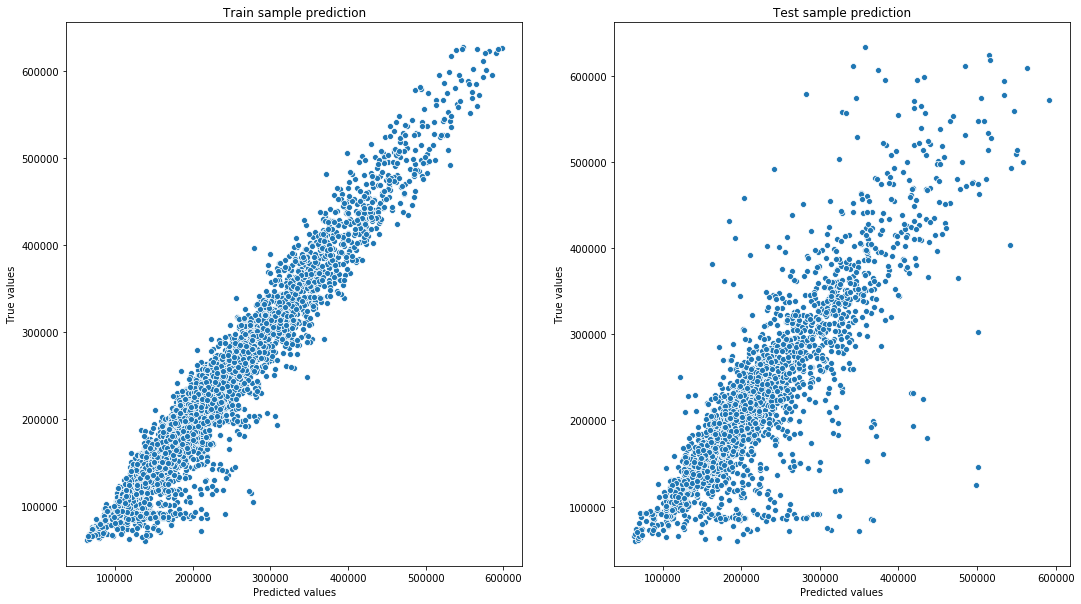

In [967]:
y_train_preds = rf_model.predict(X_train.fillna(-9999))
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [968]:
# Посмотрим важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.650560
1,Square,0.093222
20,dist_price_m2,0.044022
19,MedPriceByRoomsYear,0.037942
3,KitchenSquare,0.034659
2,LifeSquare,0.022453
5,HouseFloor,0.017726
4,Floor,0.016862
6,HouseYear,0.015474
7,Ecology_1,0.012475


In [969]:
price_test = rf_model.predict(X_test.fillna(-9999))

In [970]:
price_test.shape

(5000,)

In [971]:
#По условию: Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).
# Поэтому создадим индекс и сформируем датафрейм.
index_test = np.linspace(1, 5000, 5000)

In [972]:
index_test.shape

(5000,)

In [973]:
y_test_dict = {
    "Id": index_test,
    "Price": price_test
}

y_test = pd.DataFrame(y_test_dict)

y_test['Id'] = y_test['Id'].astype(int)

y_test

,Id,Price
0,1,160807.855907
1,2,235003.261353
2,3,196222.526463
3,4,252854.686708
4,5,138178.317492
...,...,...
4995,4996,247913.339403
4996,4997,137184.023185
4997,4998,310513.039489
4998,4999,187126.735827


In [974]:
y_test.to_csv('MALyakishev_predictions.csv', index=False, encoding='utf-8')